In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from twitter.twitter_collection import TwitterCollection
from twitter.tweet_sentiment_analyzer import TweetSentimentAnalyzer
from data_pipelines.data_manipulation import DataManipulation

import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

Python-dotenv could not parse statement starting at line 11
[nltk_data] Downloading package stopwords to /home/kozan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
client_twitter = TwitterCollection()
df_btc = client_twitter.get_tweets_df('bitcoin', pathdf='../data/tweets_data/btc/', filedf='btc_tweets.csv')

Authentication Successfull


In [3]:
tsa = TweetSentimentAnalyzer(df_btc)

In [4]:
df = tsa.cleaning_tweet_data(df_btc)

In [5]:
df = tsa.preprocessing_tweet_datetime(df)

In [6]:
df = tsa.get_sentiment_scores(df)

In [7]:
tsa.add_datetime_to_col(df)

In [8]:
df_result = tsa.get_sent_with_mean_interval(df, interval='1d')

In [9]:
ohlc = yf.download('BTC-USD', start='2022-10-16', end='2022-11-24', interval='1h')

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Sentiment Score')

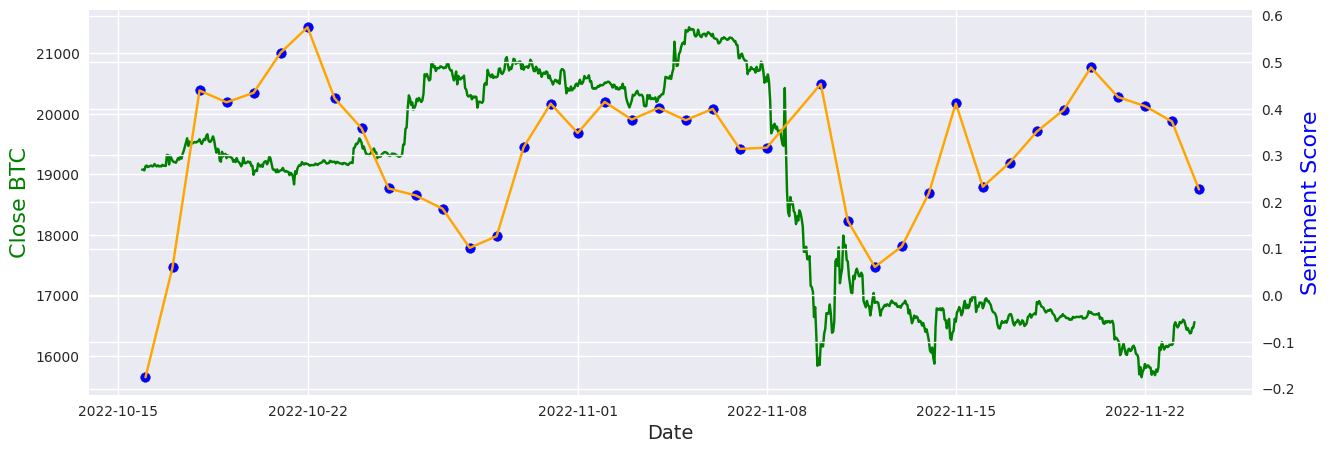

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ohlc.index, ohlc.Close, color='green')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Close BTC', color='green', fontsize=16)

ax2 = ax.twinx()
ax2.scatter(df_result.index, df_result.compound_total, color='blue')
ax2.plot(df_result.index, df_result.compound_total, color='orange')
ax2.set_ylabel('Sentiment Score', color='blue', fontsize=16)

In [11]:
com_words = tsa.get_most_common_words(df, 10)
com_words.style.background_gradient(cmap='Blues')

,Common_words,count
0,0,4084
1,price,3922
2,1,2980
3,btc,2071
4,buy,1750
5,usd,1616
6,5,1613
7,last,1458
8,2,1318
9,n,1142


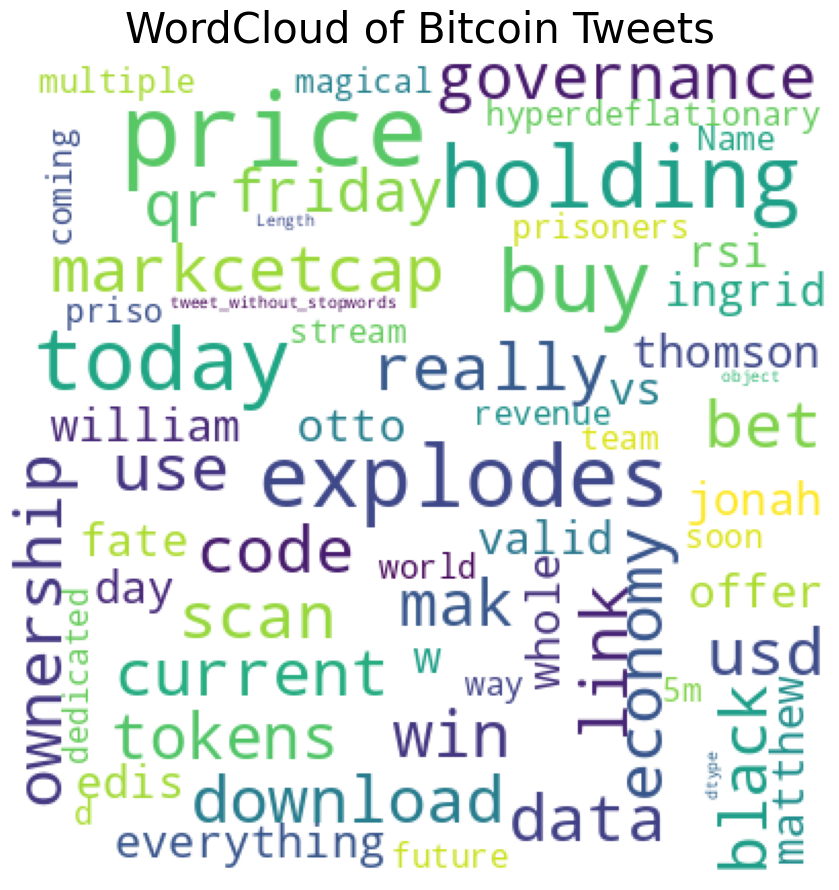

In [12]:
tsa.plot_wordcloud(df['tweet_without_stopwords'],mask=None,color='white',
                max_font_size=50,title_size=30,title="WordCloud of Bitcoin Tweets")